# Monthly Significant Rules by Administration

Data manipulation and plotting converted from `charts/code/monthly_sig_rules_by_admin.Rmd`.

In [1]:
import textwrap
from datetime import datetime
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utilis.style import GW_COLORS
from utilis.local_utilis import ydynam

## Config

In [2]:
DATA_FILE = "data/monthly_significant_rules_by_admin.csv"
OUTPUT_DIR = "output"
presidential_admin = "Biden"  # e.g. "Biden", "Trump 47"

## Load and prepare data

In [3]:
base = Path(".").resolve()
data_path = base / DATA_FILE
monthly_sig0 = pd.read_csv(data_path)

In [4]:
monthly_sig1 = monthly_sig0.copy()
monthly_sig1["Year"] = monthly_sig1["Year"].astype(str)
monthly_sig1["Date"] = pd.to_datetime(
    "01-" + monthly_sig1["Month"] + "-" + monthly_sig1["Year"],
    format="%d-%b-%Y",
)
# Relocate Date after Month
cols = list(monthly_sig1.columns)
month_idx = cols.index("Month")
cols.insert(month_idx + 1, cols.pop(cols.index("Date")))
monthly_sig1 = monthly_sig1[cols]

In [5]:
# Pivot long: Economically Significant, Other Significant -> Rule.Type, Rule.Number
value_cols = ["Economically Significant", "Other Significant"]
id_cols = [c for c in monthly_sig1.columns if c not in value_cols]
monthly_sig2 = monthly_sig1.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="Rule.Type",
    value_name="Rule.Number",
)

rule_type_order = ["Other Significant", "Economically Significant"]
monthly_sig2["Rule.Type"] = pd.Categorical(
    monthly_sig2["Rule.Type"],
    categories=rule_type_order,
    ordered=True,
)

monthly_sig = monthly_sig2[monthly_sig2["Admin"] == presidential_admin].copy()
monthly_sig.head()

,Admin,Year,Month,Date,Months in Office,Significant,Rule.Type,Rule.Number
486,Biden,2021,Jan,2021-01-01,0,0.0,Economically Significant,0.0
487,Biden,2021,Feb,2021-02-01,1,9.0,Economically Significant,6.0
488,Biden,2021,Mar,2021-03-01,2,11.0,Economically Significant,4.0
489,Biden,2021,Apr,2021-04-01,3,9.0,Economically Significant,2.0
490,Biden,2021,May,2021-05-01,4,16.0,Economically Significant,10.0


## Plot

/var/folders/zp/7qktvyk137s1mql4gxlf81s40000gn/T/ipykernel_42698/2301299220.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


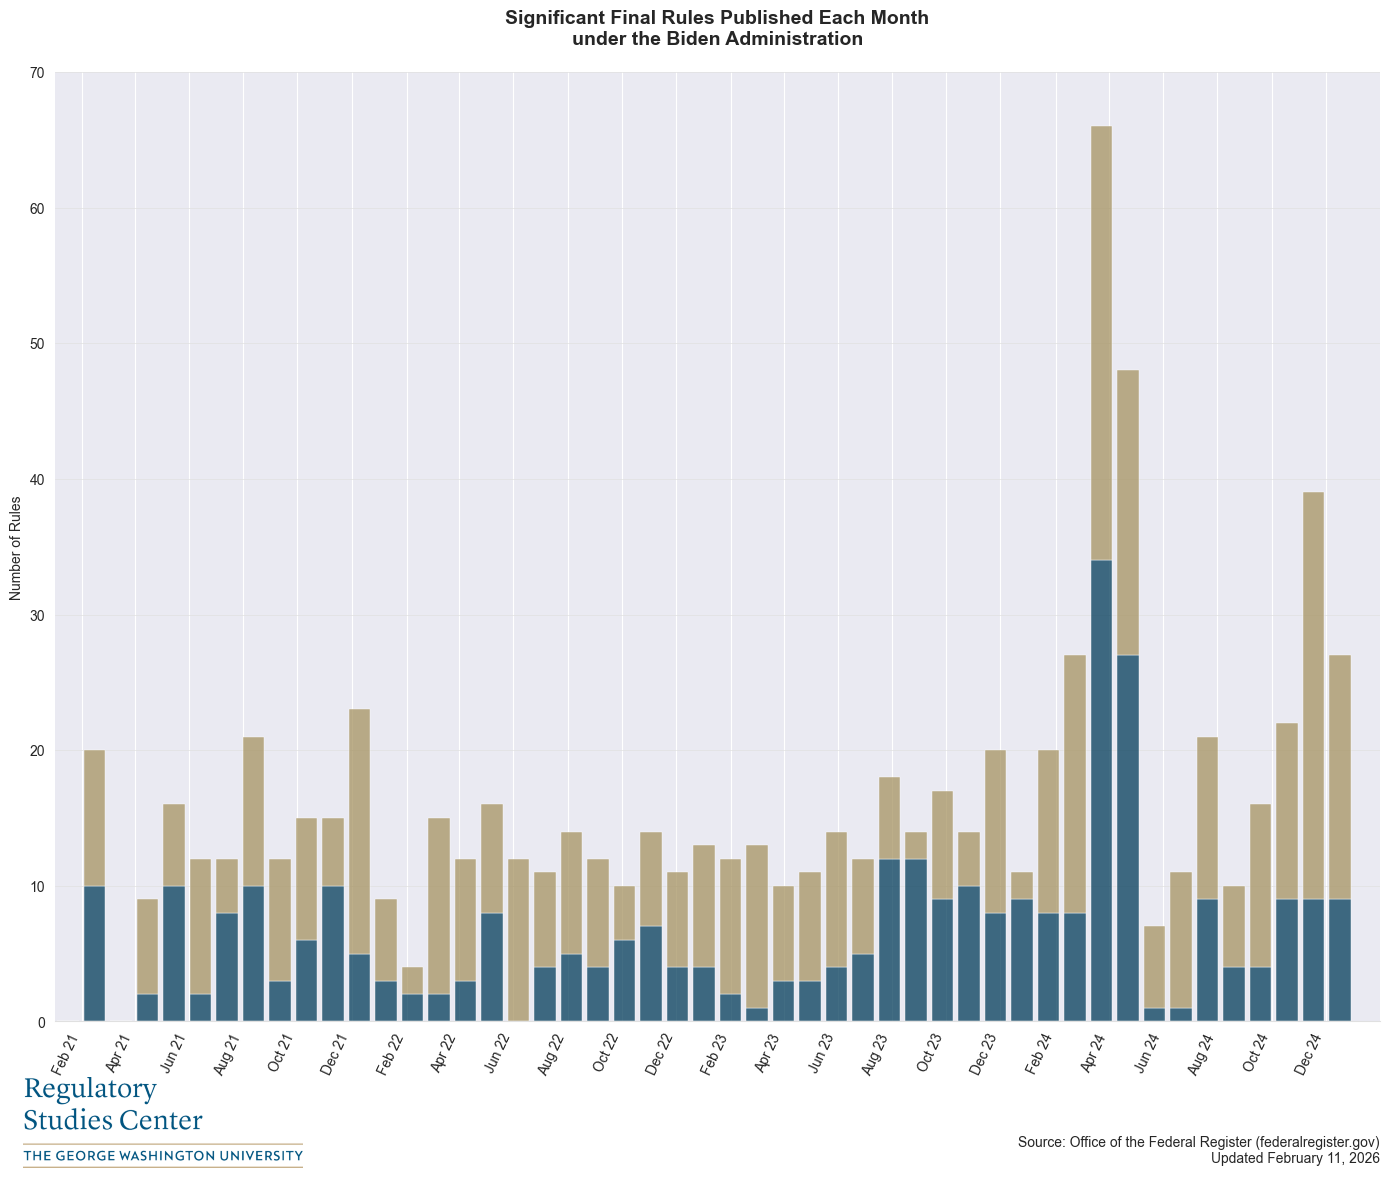

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

monthly_totals = monthly_sig.groupby("Date")["Rule.Number"].sum().reset_index()
y_limit = ydynam(monthly_totals, 10, "Rule.Number")

palette = {
    "Economically Significant": GW_COLORS["GWblue"],
    "Other Significant": GW_COLORS["GWbuff"],
}

sns.histplot(
    data=monthly_sig,
    x="Date",
    weights="Rule.Number",
    hue="Rule.Type",
    multiple="stack",
    palette=palette,
    shrink=0.8,
    edgecolor="white",
    linewidth=0.3,
    bins=len(monthly_sig["Date"].unique()) or 48,
    ax=ax,
)

ax.set_ylim(0, y_limit)
ax.set_xlim(pd.Timestamp("2021-01-01"), pd.Timestamp("2025-01-31"))  # Jan 21 to Jan 25
ax.set_yticks(range(0, int(y_limit) + 1, 10))
ax.set_title(
    f"Significant Final Rules Published Each Month\nunder the {presidential_admin} Administration",
    pad=20,
    fontsize=12,
    fontweight="bold",
    ha="center",
)
ax.set_ylabel("Number of Rules")
ax.set_xlabel("")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax.get_xticklabels(), rotation=65, ha="right")

ax.spines[["top", "right", "left"]].set_visible(False)
ax.spines["bottom"].set_color(GW_COLORS["RSCgray"])
ax.grid(axis="y", color=GW_COLORS["RSCgray"], linestyle="-", linewidth=0.5)
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1],
    ["Economically Significant", "Other Significant"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=False,
    fontsize=12,
)

current_date = datetime.now().strftime("%B %d, %Y")
caption_text = (
    f"Source: Office of the Federal Register (federalregister.gov)\n\nUpdated {current_date}"
)
wrapped_caption = "\n".join(textwrap.wrap(caption_text, width=65))
ax.text(1, -0.12, wrapped_caption, transform=ax.transAxes, fontsize=10, ha="right", va="top")

# Logo in bottom-left corner
import matplotlib.image as mpimg
logo_path = base / "utilis/style/gw_ci_rsc_2cs_pos.png"
if logo_path.exists():
    logo_img = mpimg.imread(logo_path)
    logo_ax = fig.add_axes([0.02, 0.02, 0.2, 0.08])
    logo_ax.imshow(logo_img)
    logo_ax.axis("off")

fig.tight_layout()
plt.show()

## Save (optional)

In [ ]:
out_dir = base / OUTPUT_DIR
out_dir.mkdir(parents=True, exist_ok=True)
slug = presidential_admin.lower().replace(" ", "_")
name = f"monthly_significant_rules_{slug}"
fig.savefig(out_dir / f"{name}.pdf", dpi=300, bbox_inches="tight")
fig.savefig(out_dir / f"{name}.png", dpi=96, bbox_inches="tight", facecolor="white")
print(f"Saved to {out_dir / name}.pdf and .png")